### Problem Statement
The task is to predict whether a potential promotee at checkpoint in the test set will be promoted or not after the evaluation process. 

In [24]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb
import seaborn as sb
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [25]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [26]:
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [27]:
train_data='D:/My Personal Documents/Learnings/Data Science/Data Sets/WNS Analytics/train_LZdllcl.csv'
test_data='D:/My Personal Documents/Learnings/Data Science/Data Sets/WNS Analytics/test_2umaH9m.csv'
train_result='D:/My Personal Documents/Learnings/Data Science/Data Sets/WNS Analytics/train_result.csv'

In [28]:
train=pd.read_csv(train_data)
test=pd.read_csv(test_data)
test_results = pd.read_csv(train_result)

In [29]:
target = 'is_promoted'
IDcol = 'employee_id'

In [30]:
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
print (train.shape, test.shape, data.shape)

(54808, 15) (23490, 14) (78298, 15)


C:\Amrendra\Anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




In [31]:
def age_trans(age):
    if(age<30):
        return 'Young'
    elif(age>=30 and age<40):
        return 'Middle Age'
    elif(age >=40):
        return 'Senior'

In [32]:
data['age']=data['age'].apply(age_trans)

In [33]:
def rating_trans(rating): 
    if(rating>=4.0): 
        return 'High' 
    elif(rating==3.0): 
        return 'Medium' 
    elif(rating < 3.0): 
        return 'low'

In [34]:
data['previous_year_rating']=data['previous_year_rating'].apply(rating_trans)

In [35]:
data.previous_year_rating[data.previous_year_rating.isnull()]=3.0

C:\Amrendra\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [36]:
data.education[data.education.isnull()]="Bachelor's"

C:\Amrendra\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [37]:
data=pd.get_dummies(data,columns=['department','education','gender','recruitment_channel','age','previous_year_rating','region'])

In [38]:
train=data[data.source=='train']
train.drop('source',axis=1,inplace=True)
test=data[data.source=='test']
test.drop(['source','is_promoted'],axis=1,inplace=True)

C:\Amrendra\Anaconda\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [39]:
x=train.drop('is_promoted',axis=1)

In [40]:
y=train["is_promoted"]

In [99]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=22)

In [109]:
decision_tree=tree.DecisionTreeClassifier()
decision_tree.fit(x_train,y_train)
y_pred=decision_tree.predict(x_test)

In [110]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

In [111]:
roc_auc

0.6980934624499426

In [45]:
cv=KFold(n_splits=10)
accuracies=list()
max_attributes=len(list(train))
depth_range=range(1,max_attributes+1)

In [47]:
for depth in depth_range:
    fold_accuracy=[]
    tree_model=tree.DecisionTreeClassifier(max_depth=depth)
    for train_fold,valid_fold in cv.split(train):
        f_train=train.loc[train_fold]
        f_valid=train.loc[valid_fold]
        
        model=tree_model.fit(X=f_train.drop(['is_promoted'],axis=1),y=f_train['is_promoted'])
        valid_acc=model.score(X=f_valid.drop(['is_promoted'],axis=1),y=f_valid['is_promoted'])
        fold_accuracy.append(valid_acc)
        
    avg=sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)

In [48]:
df=pd.DataFrame({'Max Depth': depth_range,"Average Accuracy": accuracies})  
df=df[['Max Depth','Average Accuracy']]
print(df.to_string(index=False))

Max Depth  Average Accuracy
        1          0.922803
        2          0.922511
        3          0.923186
        4          0.925814
        5          0.929718
        6          0.931251
        7          0.932090
        8          0.932291
        9          0.935958
       10          0.936706
       11          0.936597
       12          0.937181
       13          0.936360
       14          0.936159
       15          0.934681
       16          0.933313
       17          0.931068
       18          0.928879
       19          0.926598
       20          0.924299
       21          0.921435
       22          0.919446
       23          0.916855
       24          0.914191
       25          0.911637
       26          0.910123
       27          0.907294
       28          0.904959
       29          0.903791
       30          0.902149
       31          0.901036
       32          0.899923
       33          0.899339
       34          0.899066
       35          0

In [49]:
y_train1=train['is_promoted']
x_train1=train.drop('is_promoted',axis=1).values
x_test1=test.values

In [50]:
decision_tree=tree.DecisionTreeClassifier(max_depth=12)
decision_tree.fit(x_train1,y_train1)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [53]:
employee_id=test['employee_id']

In [54]:
y_pred=decision_tree.predict(x_test1)
submission=pd.DataFrame({"employee_id":employee_id, "is_promoted":y_pred})
submission.to_csv('submission.csv',index=False)

In [60]:
with open('tree2.dot','w') as f:
    f=tree.export_graphviz(decision_tree,
                          out_file=f,
                          max_depth=12,
                          impurity=True,
                          feature_names=list(train.drop(['is_promoted'],axis=1)),
                          class_names=['Died','is_promoted'],
                          rounded=True,
                          filled=True)

In [61]:
check_call(['dot','-Tpng','tree2.dot','-o','tree2.png'])

0

In [62]:
img=Image.open("tree2.png")
draw=ImageDraw.Draw(img)
draw.text((10,0),
         '"Title<=1.5" corresponds to "Mr."Title',
         (0,0,255)
         )
img.save('sample-out.png')
PImage("sample-out.png")

### Below codes were used for tuning the parameters

In [64]:
len(train.columns)-50

15

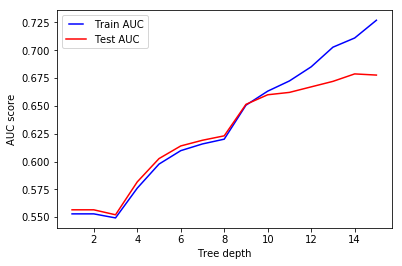

In [65]:
from sklearn.tree import DecisionTreeClassifier
max_depths = np.linspace(1, len(train.columns)-50, len(train.columns)-50, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

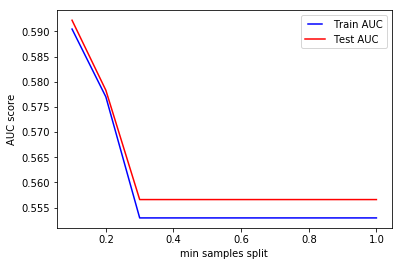

In [66]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

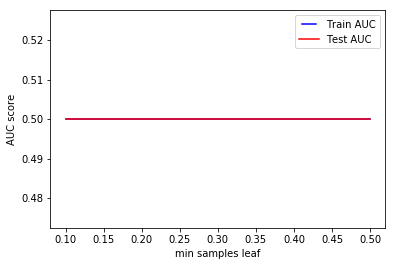

In [67]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r',label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

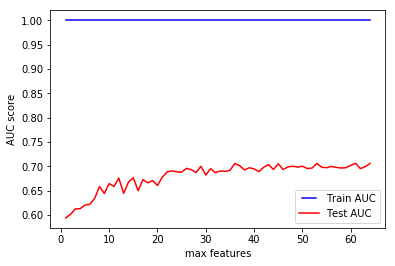

In [69]:
max_features = list(range(1,train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   dt = DecisionTreeClassifier(max_features=max_feature)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

In [ ]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_